#References

##Data
https://www.kaggle.com/sharmayush/person2anime/activity

##Model 
https://github.com/arnab39/cycleGAN-PyTorch/blob/master/model.py

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

https://arxiv.org/pdf/1703.10593.pdf

# Imports

In [10]:
# IMPORTANT PLEASE READ
# Please downgrade your Pytorch to 1.4.0 if your computer is installed with the newer versions
# https://pytorch.org/get-started/previous-versions/

# Conda:
# conda install pytorch==1.4.0 torchvision==0.5.0 cudatoolkit=10.1 -c pytorch

# MAC OS X
# conda install pytorch==1.4.0 torchvision==0.5.0 -c pytorch

In [1]:
import torch.nn as nn
import torch
import itertools
import os
import shutil
import time

import torch.nn.functional as F
import torchvision.transforms as transforms
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.6.0+cu101'

In [3]:
# This code is to remove results from the previous run
# DO NOT run this if you first run this code
shutil.rmtree("weeb_predictions")
shutil.rmtree("weeb_checkpoints")

FileNotFoundError: ignored

In [3]:
# Make diretories for checkpoints and predictions
os.makedirs("weeb_predictions/A/", exist_ok=True)
os.makedirs("weeb_predictions/B/", exist_ok=True)
os.makedirs("weeb_checkpoints/", exist_ok=True)

In [4]:
# GPU settings and training dataset size
# If you don't have GPU, set use_cuda = True
# However this entirely instance is optimized towards training with GPU
# We recommend running this entire notebook on Google Colab if you don't have a GPU

use_cuda = True
multiGPU = False
use_dropout = True
dataset_size = 3400

In [5]:
# Scale-factor for number of parameters to train
# Dr. Zhu suggests 64 in his paper

PM = 64

In [6]:
# Root directory, change this according to your local directory
root = '.'

dir_A = root+'/datasets/face2anime/trainA'
dir_B = root+'/datasets/face2anime/trainB'
t_dir_A = root+'/datasets/face2anime/testA'
t_dir_B = root+'/datasets/face2anime/testB'

In [7]:
_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

SetA = torchvision.datasets.ImageFolder(root=dir_A, transform=_transform)
SetB = torchvision.datasets.ImageFolder(root=dir_B, transform=_transform)
testA = torchvision.datasets.ImageFolder(root=t_dir_A, transform=_transform)
testB = torchvision.datasets.ImageFolder(root=t_dir_A, transform=_transform)
#instance = ([3,128,128],0)

FileNotFoundError: ignored

In [8]:
A_Shuffle=True
B_Shuffle=True

# Change batch size here
Batch_size= 1
num_workers = 1

LoaderA = torch.utils.data.DataLoader(SetA, batch_size=Batch_size,shuffle=A_Shuffle, num_workers=num_workers)
LoaderB = torch.utils.data.DataLoader(SetB, batch_size=Batch_size,shuffle=B_Shuffle, num_workers=num_workers)

# There isn't a point to randomly shuffle tht test sets
# No shuffling for more convenient indexing
LoadertestA = torch.utils.data.DataLoader(testA, batch_size=Batch_size, shuffle=False, num_workers=num_workers)
LoadertestB = torch.utils.data.DataLoader(testB, batch_size=Batch_size, shuffle=False, num_workers=num_workers)

NameError: ignored

# Models


## Generator

In [8]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, use_dropout):
        super(ResnetBlock, self).__init__()
        self.model = self.buildBlock(dim, use_dropout)
    
    def buildBlock(self, dim, use_dropout, pm=PM):
        self.model = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(pm * 4),
            nn.ReLU(True),
            
            nn.Dropout(p=0.5),

            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 4, kernel_size=3, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(pm * 4)  
        )
        return self.model
        
    def forward(self, input):
        # Add skip connection
        out = input + self.model(input)
        return out

In [11]:
class Generator_Res(nn.Module):
    def __init__(self, inchannels = 3, outchannels = 3, pm=PM):
        super(Generator_Res, self).__init__()
        self.model = nn.Sequential(
            
            #Downsampling
            nn.ReflectionPad2d(3),

            nn.Conv2d(in_channels=inchannels, out_channels=pm*1, kernel_size=7, stride=1, padding=0, bias=True),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True),

            nn.Conv2d(in_channels=pm*1, out_channels=pm * 2, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),

            nn.Conv2d(in_channels=pm*2, out_channels=pm*4, kernel_size=3, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(pm * 4),
            nn.ReLU(True),

            #Resblocks # 1
            ResnetBlock(dim=64, use_dropout=use_dropout),
            #Resblocks # 2
            ResnetBlock(dim=64, use_dropout=use_dropout),
            #Resblocks # 3
            ResnetBlock(dim=64, use_dropout=use_dropout),
            #Resblocks # 4
            ResnetBlock(dim=64, use_dropout=use_dropout),
            #Resblocks # 5
            ResnetBlock(dim=64, use_dropout=use_dropout),
            #Resblocks # 6
            ResnetBlock(dim=64, use_dropout=use_dropout),
            
            #Upsampling
            nn.ConvTranspose2d(in_channels=pm * 4, out_channels=pm * 2, kernel_size=3, stride=2, padding=1,
                               output_padding=1),
            nn.InstanceNorm2d(pm * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=pm * 2, out_channels=pm * 1, kernel_size=3, stride=2, padding=1,
                               output_padding=1),
            nn.InstanceNorm2d(pm * 1),
            nn.ReLU(True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(pm, outchannels, 7),
            nn.Tanh()
        )

        if (multiGPU):
            self.model = nn.DataParallel(self.model)
            
    def forward(self, x):
        return self.model(x)

## Discriminator


In [12]:
class Discriminator_Patch(nn.Module):
    def __init__(self, inchannels = 3, outchannels=1, pm=PM):
        super(Discriminator_Patch, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=inchannels, out_channels=pm *1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels = pm * 1, out_channels=pm * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(pm * 2),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 2, out_channels=pm * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(pm * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 4, out_channels=pm * 8, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(pm * 4),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(in_channels=pm * 8, out_channels=outchannels, kernel_size=4, stride=1, padding=1)
        )
        if (multiGPU):
            self.model = nn.DataParallel(self.model)

    def forward(self, x):
        return self.model(x)

# Training Function

In [13]:
def train(LoaderA, LoaderB, Gen_A, Gen_B, Dis_A, Dis_B, G_lambda=10, G_idtcoeff=0.5, g_lr=0.05, d_lr=0.05, epochs=100):
    # Clear cache
    if use_cuda:
        torch.cuda.empty_cache()
    
    criterionMSE = nn.MSELoss()
    criterionL1 = nn.L1Loss()
    
    # Set-up the optimizer
    G_optimizer = torch.optim.Adam(itertools.chain(Gen_A.parameters(),Gen_B.parameters()), lr=g_lr, betas=(0.5, 0.999))
    D_optimizer = torch.optim.Adam(itertools.chain(Dis_A.parameters(), Dis_B.parameters()), lr=d_lr, betas=(0.5, 0.999))

    if use_cuda and torch.cuda.is_available():
        Gen_A = Gen_A.cuda()
        Gen_B = Gen_B.cuda()
        Dis_A = Dis_A.cuda()
        Dis_B = Dis_B.cuda()
        print("cuda training")
    else:
        print("cpu training")

    track_loss = []
    
    for epoch in range(epochs):
        
        epoch_start_time = time.time()
        
        # Learning rate decay for over 100 epochs
        if epoch > 100:
            g_lr *= 0.993
            d_lr *= 0.993
        
        for i, (_a_real, _b_real) in enumerate(zip(LoaderA, LoaderB)):

            #remove label from imagefolder
            a_real = _a_real[0] 
            b_real = _b_real[0]
            if use_cuda and torch.cuda.is_available():
                a_real=a_real.cuda()
                b_real=b_real.cuda()
                
            #A: faces
            #B: anime
            #Generators
            
            # -----------------------------
            # Anime Cycle: B -> A' -> B^ === b_real -> a_fake -> b-recon
            # -----------------------------
            
            G_optimizer.zero_grad()
            a_fake = Gen_B(b_real)
            a_dis_pred = Dis_B(a_fake)
            
            # Create a truth label
            label_1 = torch.ones(a_dis_pred.size())
            if use_cuda and torch.cuda.is_available():
                label_1 = label_1.cuda()
            # Generator MSE loss
            b_gen_loss = criterionMSE(a_dis_pred, label_1)
            
            b_recon = Gen_A(a_fake)
            b_cycle_loss = criterionL1(b_recon, b_real) * G_lambda
            
            b_idt = Gen_B(a_real)
            b_idt_losses = criterionL1(b_idt, a_real) * G_lambda * G_idtcoeff
            
            b_total_loss = b_gen_loss + b_cycle_loss + b_idt_losses
            b_total_loss.backward(retain_graph=True)
            G_optimizer.step()
            
            # -----------------------------
            # Selfie Cycle: A -> B' -> A^
            # -----------------------------
            
            G_optimizer.zero_grad()
            b_fake = Gen_A(a_real)
            b_dis_pred = Dis_A(b_fake)
            # Create a truth label
            label_1 = torch.ones(b_dis_pred.size())
            if use_cuda and torch.cuda.is_available():
                label_1 = label_1.cuda()
            a_gen_loss = criterionMSE(b_dis_pred, label_1)
            
            a_recon = Gen_B(b_fake)
            a_cycle_loss = criterionL1(a_recon, a_real) * G_lambda
            
            a_idt = Gen_A(b_real)
            a_idt_losses = criterionL1(a_idt, b_real) * G_lambda * G_idtcoeff
            
            a_total_loss = a_gen_loss + a_cycle_loss + a_idt_losses
            a_total_loss.backward(retain_graph=True)
            G_optimizer.step()
            
            # -----------------------------
            # B Discriminators
            # -----------------------------
            D_optimizer.zero_grad()
            
            # Real
            b_real_dis = Dis_B(a_real)
            
            dlabel_1 = torch.ones(b_real_dis.size())
            if use_cuda and torch.cuda.is_available():
                dlabel_1 = dlabel_1.cuda()
            
            b_dis_real_loss = criterionMSE(b_real_dis, dlabel_1)
            
            # Fake
            b_fake_dis = Dis_B(a_fake)
            dlabel_0 = torch.zeros(b_fake_dis.size())
            if use_cuda and torch.cuda.is_available():
                dlabel_0 = dlabel_0.cuda()
            
            b_dis_fake_loss = criterionMSE(b_fake_dis, dlabel_0)
            
            # Step optimizer and backprop
            b_dis_loss = (b_dis_real_loss + b_dis_fake_loss) * 0.5
            b_dis_loss.backward()
            D_optimizer.step()
            
            # -----------------------------
            # A Discriminators
            # -----------------------------
            D_optimizer.zero_grad()
            
            # Real
            a_real_dis = Dis_A(b_real)
            
            dlabel_1 = torch.ones(a_real_dis.size())
            if use_cuda and torch.cuda.is_available():
                dlabel_1 = dlabel_1.cuda()
            
            a_dis_real_loss = criterionMSE(a_real_dis, dlabel_1)
            
            # Fake
            a_fake_dis = Dis_A(b_fake)
            dlabel_0 = torch.zeros(a_fake_dis.size())
            if use_cuda and torch.cuda.is_available():
                dlabel_0 = dlabel_0.cuda()
            
            a_dis_fake_loss = criterionMSE(a_fake_dis, dlabel_0)
            
            # Step optimizer and backprop
            a_dis_loss = (a_dis_real_loss + a_dis_fake_loss) * 0.5
            a_dis_loss.backward()
            D_optimizer.step()
            
            if i % (dataset_size//(Batch_size*5)) == 0:
                print("Epoch", epoch, " Iteration ", i)
                print("A dis_loss: ", a_dis_loss.item())
                print("B dis_loss: ", b_dis_loss.item())
                print("A total_loss: ", a_total_loss.item())
                print("B total_loss: ", b_total_loss.item())
                
                # A
                filename = "face2anime_SelfieCycle" + '_epoch_%03d_%04d.png' % (epoch, i,)
                save_path = os.path.join('weeb_predictions/A/', filename)
                A_grid = torch.cat((b_real,a_fake,b_recon),dim=0)
                torchvision.utils.save_image(A_grid, save_path, nrow=3, normalize=True)
                
                # B
                filename = "face2anime_AnimeCycle" + '_epoch_%03d_%04d.png' % (epoch, i,)
                save_path = os.path.join('weeb_predictions/B/', filename)
                B_grid = torch.cat((a_real,b_fake,a_recon),dim=0)
                torchvision.utils.save_image(B_grid, save_path, nrow=3, normalize=True)
                

        # For each epoch
        # Saves 
        epoch_loss = {
            'a_gen_loss':a_gen_loss.item(),
            'b_gen_loss':b_gen_loss.item(),
            'a_cycle_loss':a_cycle_loss.item(),
            'b_cycle_loss':b_cycle_loss.item(),
            'a_idt_losses':a_idt_losses.item(),
            'b_idt_losses':b_idt_losses.item(),
            'a_dis_real_loss':a_dis_real_loss.item(),
            'a_dis_fake_loss':a_dis_fake_loss.item(),
            'b_dis_real_loss':b_dis_real_loss.item(),
            'b_dis_fake_loss':b_dis_fake_loss.item(),
            'a_dis_loss':a_dis_loss.item(),
            'b_dis_loss':b_dis_loss.item()
        }
        track_loss.append(epoch_loss)
  
        if epoch % 5 == 0:
            save_filename = f'{"face2anime"}_netG_{epoch}.pt'
            save_filepath = os.path.join('weeb_checkpoints/', save_filename) 
            torch.save({"epoch_loss":track_loss,
                        'Gen_A_state_dict':Gen_A.state_dict(),
                        'Gen_B_state_dict':Gen_B.state_dict(),
                        'Dis_A_state_dict': Dis_A.state_dict(),
                        'Dis_B_state_dict': Dis_B.state_dict(),
                        "G_optimizer":G_optimizer.state_dict(),
                        "D_optimizer":D_optimizer.state_dict()
                       }
                       , save_filepath)

        epoch_time = int(time.time() - epoch_start_time)
        print("This epoch took %.3d secs"%epoch_time)
        print("-------------------------------------")
    return Gen_A, Gen_B, track_loss


# Training

In [9]:
# Initialize the Generators
Gen_A = Generator_Res()
Gen_B = Generator_Res()
Dis_A = Discriminator_Patch()
Dis_B = Discriminator_Patch()

# Start Training
women_generator, waifu_generator, track_loss = train(LoaderA, LoaderB, Gen_A, Gen_B, Dis_A, Dis_B, G_lambda=10, G_idtcoeff=0.5,
                                         g_lr=0.0002, d_lr=0.0002, epochs=100)

NameError: ignored

# Load and Test

In [16]:
# Change the below in accordance with your local directories
cp_dir = "./cp"


# COMMENT OUT THE OTHER MODEL IF YOU WANT TO RUN A PARTICULAR MODEL
# BY DEFAULT RUNS MODEL #2. Model 1 and 2 specification is provided inside the
# report.
# Model 1
# This particular checkpoint file is trained with multiGPU = True
multiGPU = True
checkpoint = torch.load(cp_dir+'/'+ "face2anime_netG_final.pth")

# Model 2
# multiGPU = False
# checkpoint = torch.load(cp_dir+'/'+ "face2anime_netG_95.pt")

In [17]:
Gen_A1 = Generator_Res()
Gen_A1.load_state_dict(checkpoint['Gen_A_state_dict'])
Gen_B1 = Generator_Res()
Gen_B1.load_state_dict(checkpoint['Gen_B_state_dict'])

<All keys matched successfully>

# Visual

In [18]:
import matplotlib.pyplot as plt

def style_transfer_make_grid(Gen_A, Gen_B, LoaderA, LoaderB, which_cycle, indices=[], n_img = 3, plot=False):  
    
    if n_img == 0:
        n_img = 5
    
    if not indices:
        indices = []
    
    grid = torch.Tensor()
    while (len(indices) < n_img):
        r_ind = np.random.randint(0, len(LoaderA.dataset))
        indices.append(r_ind)
    print(indices)
    
    if which_cycle == "A":
    
        for index in indices:
            loadedA = LoaderA.dataset[index][0]
            A_in = loadedA.unsqueeze(0).cpu()
            fake_B = Gen_A(loadedA.unsqueeze(0)).cpu()
            A_recon = Gen_B(loadedA.unsqueeze(0)).cpu()

            new_grid = torch.cat((A_in,fake_B,A_recon),dim=0)
            grid = torch.cat((grid,new_grid),dim=0)
    
    if which_cycle == "B":

        for index in indices:
            loadedB = LoaderB.dataset[index][0]
            B_in = loadedB.unsqueeze(0).cpu()
            fake_A = Gen_B(loadedB.unsqueeze(0)).cpu()
            B_recon = Gen_A(loadedB.unsqueeze(0)).cpu()

            new_grid = torch.cat((B_in,fake_A,B_recon),dim=0)
            grid = torch.cat((grid,new_grid),dim=0)
            
    show_grid = torchvision.utils.make_grid(grid, nrow=3, normalize=True).detach().numpy()
    plt.figure(figsize = (15,15))
    plt.axis('off')
    plt.imshow(np.transpose(show_grid, (1,2,0)), interpolation='nearest')
    
def style_transfer_one_img(Gen_A, Gen_B, loadedA):  
    
    grid = torch.Tensor()
    
    A_in = loadedA.cpu() # Assume the input is already unsqueezed
    fake_B = Gen_A(loadedA).cpu()
    A_recon = Gen_B(loadedA).cpu()

    new_grid = torch.cat((A_in,fake_B,A_recon),dim=0)
    grid = torch.cat((grid,new_grid),dim=0)
    
    show_grid = torchvision.utils.make_grid(grid, nrow=3, normalize=True).detach().numpy()
    plt.figure(figsize = (15,15))
    plt.axis('off')
    plt.imshow(np.transpose(show_grid, (1,2,0)), interpolation='nearest')
   

[75, 96, 73, 46, 64]


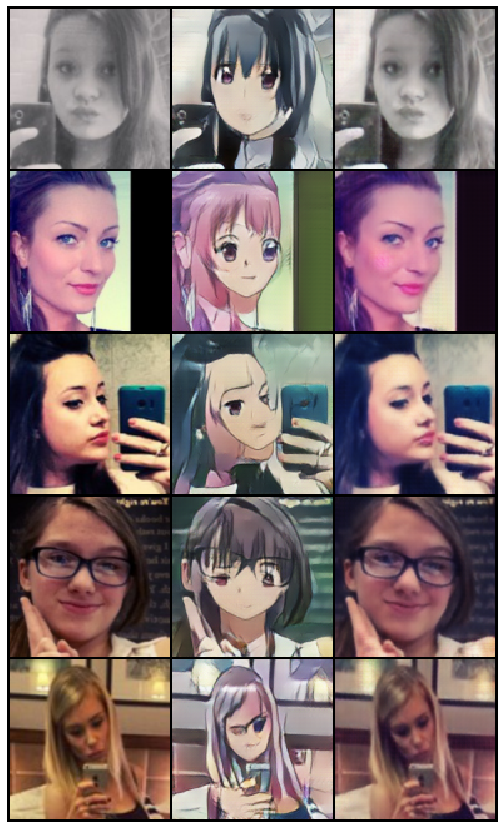

In [ ]:
# A Cycle
good_set = [63,43,2,89,11,71,68]
bad_set = [75,96,73,46,64]

# B Cycle
# good_set = [31,20,56,61]
# bad_set = [99,44,15,11]

# Change this to any set above if you want to see fixed results
# Change this to [] if you want to see random results
preset_index = bad_set

# Change the fifth parameter to "B" if you want Cycle B result
# "A" for Cycle A result
style_transfer_make_grid(Gen_A1.eval(), Gen_B1.eval(), LoadertestA, LoadertestB, "A", preset_index, n_img=len(preset_index))

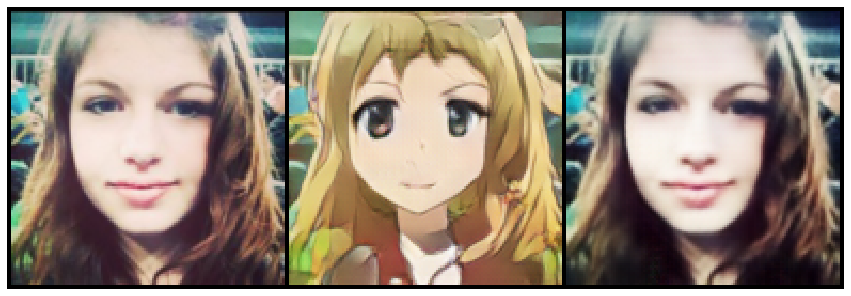

In [21]:
from PIL import Image

import torchvision.transforms.functional as TF
import torch.nn.functional as F

# Put the test image in your local directory
# test_img = Image.open("Emma_Watson_2013_edited.jpg").convert('RGB')
test_img = Image.open("female_1409.jpg").convert('RGB')

test_img = TF.resize(test_img,128)
test_img = TF.to_tensor(test_img)
normalizer = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
test_img = normalizer(test_img).unsqueeze_(0)
style_transfer_one_img(Gen_A1.eval(), Gen_B1.eval(),test_img)

# Plot

In [ ]:
def Visualize_plot(checkpoint):  

    plt.figure(figsize=(20,20))

    plt.subplot(3,1,1)
    plt.plot([item['a_dis_loss'] for item in checkpoint['epoch_loss']], label='a_dis_loss')
    plt.plot([item['b_dis_loss'] for item in checkpoint['epoch_loss']], label='b_dis_loss')
    plt.legend(loc='upper right')

    plt.subplot(3,1,2)
    plt.plot([item['a_gen_loss'] for item in checkpoint['epoch_loss']], label='A Gen')
    plt.plot([item['b_gen_loss'] for item in checkpoint['epoch_loss']], label='B Gen')
    plt.plot([item['a_cycle_loss'] for item in checkpoint['epoch_loss']], label='A Cycle')
    plt.plot([item['b_cycle_loss'] for item in checkpoint['epoch_loss']], label='B Cycle')
    plt.plot([item['a_idt_losses'] for item in checkpoint['epoch_loss']], label='A Idt')
    plt.plot([item['b_idt_losses'] for item in checkpoint['epoch_loss']], label='B Idt')
    plt.legend(loc='upper right')

    plt.subplot(3,1,3)
    plt.plot([item['a_dis_real_loss'] for item in checkpoint['epoch_loss']], label='A Real')
    plt.plot([item['a_dis_fake_loss'] for item in checkpoint['epoch_loss']], label='A Fake')
    plt.plot([item['b_dis_real_loss'] for item in checkpoint['epoch_loss']], label='B Real')
    plt.plot([item['b_dis_fake_loss'] for item in checkpoint['epoch_loss']], label='B Fake')
    plt.legend(loc='upper right')

    plt.show()


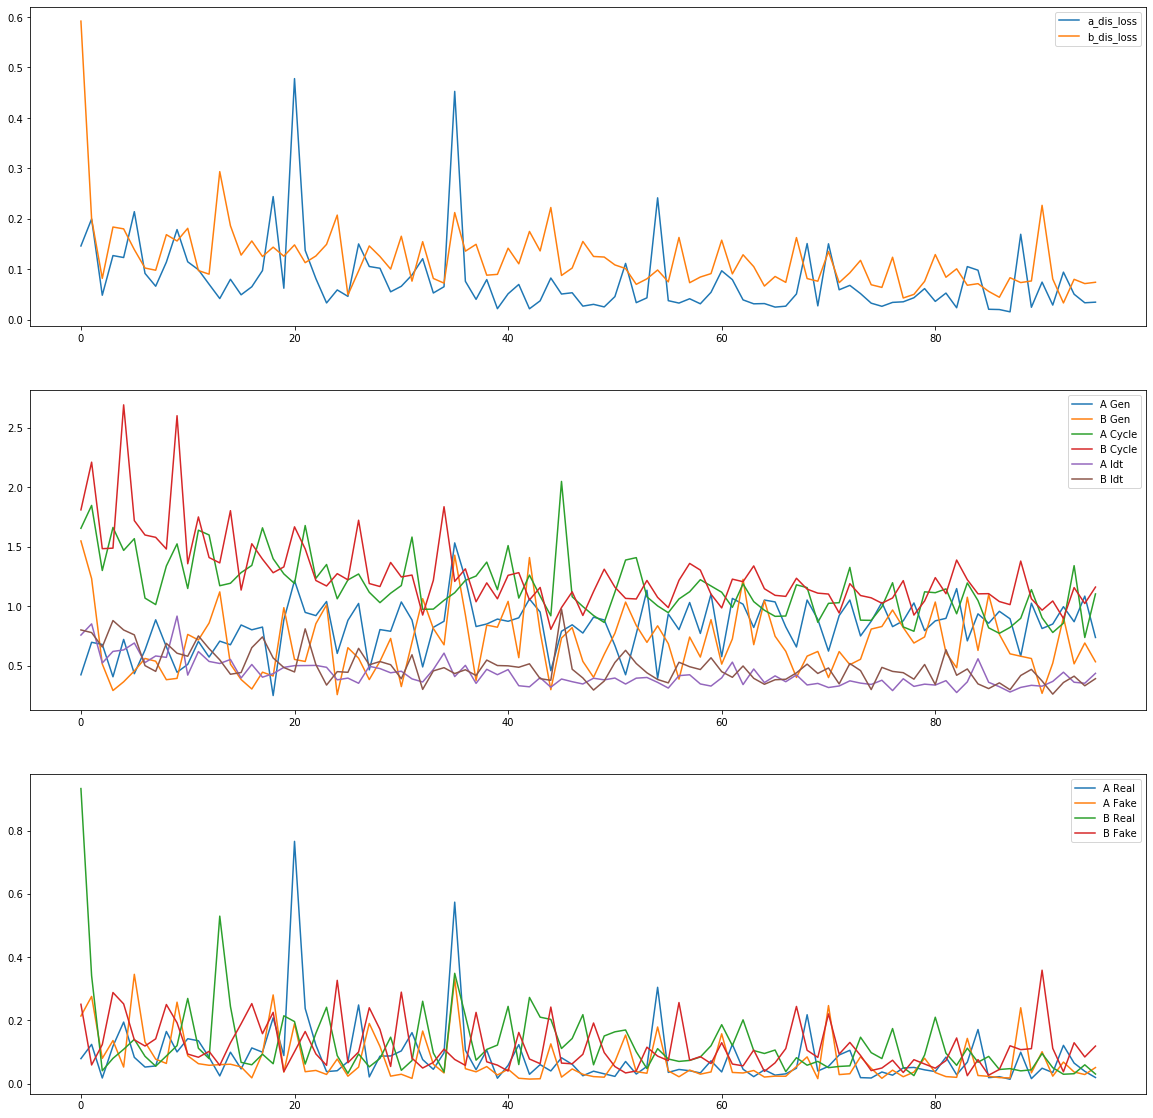

In [ ]:
Visualize_plot(checkpoint)